# Safety Prediction

    Location: Workshop
    Duration: 2019 - 2024 
    Purpose: 
    
    This project is designed to alert the superior to monitor more closely the specific technician due to his/her risk peercentage and past incident.
    

## Data Analysis
---


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Set the default Seaborn style for graphics
sb.set()


In [2]:
# Load the dataset
wsdp = pd.read_csv('workshop_incident_cleaned.csv')
wsdp['Date'] = pd.to_datetime(wsdp['Date'])

# Select numerical features for scaling
features = ['Age', 'Year of Tech', 'Experience', 'Reliability', 'Sleep', 'Temperature', 'Difficulty Level']

# Fit the StandardScaler on all features
scaler = StandardScaler()
wsdp_scaled = scaler.fit_transform(wsdp[features])
print(wsdp_scaled[:5])


[[ 4.7116097   2.38047614  3.79212135 -0.31448545  0.16552118 -1.12266699
  -1.33274983]
 [-0.23496216 -0.42008403 -1.00803226 -0.31448545  0.16552118 -1.12266699
   1.35063909]
 [-0.48229076 -0.42008403  0.19200614 -0.31448545  0.16552118 -1.12266699
   1.35063909]
 [-0.23496216 -0.42008403  0.19200614  3.17979734  0.16552118  0.31664967
  -0.43828686]
 [-0.23496216 -0.42008403  0.19200614 -0.31448545  0.16552118  0.31664967
  -1.33274983]]


C:\Users\tan_g\anaconda3\Lib\site-packages\sklearn\cluster\_agglomerative.py:1005: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


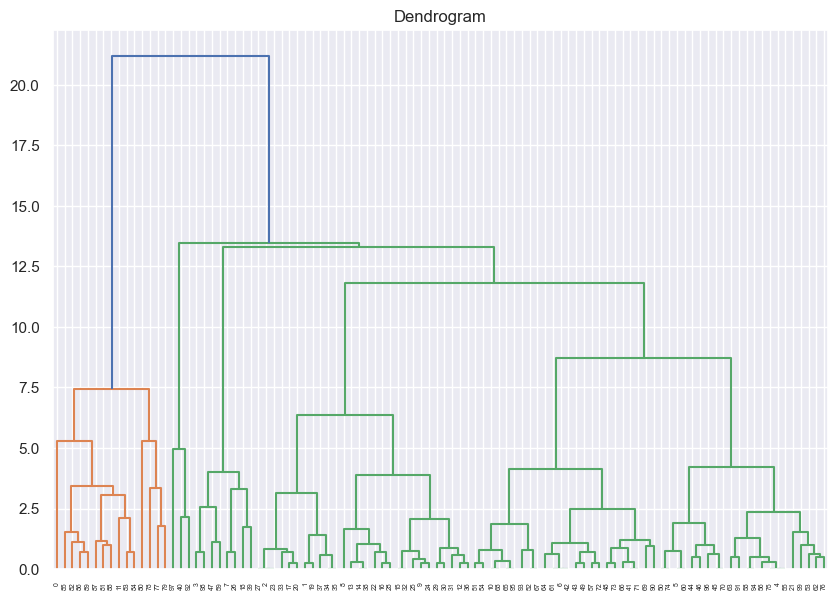

In [3]:
# Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  # Set the number of clusters
clusters = hc.fit_predict(wsdp_scaled)  # Fit the model and predict the clusters

# Add the cluster labels to the original DataFrame
wsdp['Cluster'] = clusters

# Visualize the Dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
dend = sch.dendrogram(sch.linkage(wsdp_scaled, method='ward'))
plt.show()

In [4]:
# Calculate centroids for hierarchical clusters
def calculate_centroids(data, clusters, n_clusters):
    centroids = []
    for cluster in range(n_clusters):
        cluster_points = data[clusters == cluster]
        centroid = cluster_points.mean(axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    return centroids

centroids = calculate_centroids(wsdp_scaled, clusters, n_clusters=3)

# Calculate distances to centroids
distances = np.sqrt(((wsdp_scaled - centroids[clusters]) ** 2).sum(axis=1))
wsdp['Distance_to_Centroid'] = distances

In [5]:
# Calculate silhouette score
sil_score = silhouette_score(wsdp_scaled, clusters)
print(f'Silhouette Score: {sil_score:.3f}')

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(wsdp_scaled, clusters)
print(f'Davies-Bouldin Index: {db_index:.3f}')

# Calculate MSE
# For hierarchical clustering, calculate MSE differently as there's no direct centroid concept
#mse = mean_squared_error(wsdp_scaled, distances)
#print(f'Mean Squared Error: {mse:.3f}')

Silhouette Score: 0.490
Davies-Bouldin Index: 0.832


In [ ]:
# Function to preprocess the new data point
def preprocess_data_point(new_data_point):
    new_data_point_array = np.array(new_data_point).reshape(1, -1)
    new_data_point_scaled = scaler.transform(new_data_point_array)
    return new_data_point_scaled

# Function to check if the new data point is an anomaly
def check_anomaly(new_data_point_scaled, cluster_centers, threshold):
    # Predict the cluster label for the new data point
    distances_to_centroids = np.sqrt(((cluster_centers - new_data_point_scaled) ** 2).sum(axis=1))
    new_data_point_cluster = np.argmin(distances_to_centroids)
    distance_to_centroid = distances_to_centroids[new_data_point_cluster]
    
    print(f"Distance to centroid: {distance_to_centroid}")
    print(f"Anomaly threshold: {threshold}")
    if distance_to_centroid > threshold:
        print("New data point is flagged as an anomaly.")
    else:
        print("New data point is NOT flagged as an anomaly.")


# Set the anomaly threshold
threshold = np.mean(distances) + 2 * np.std(distances)

# Example usage
while True:
    new_data_point = [float(input(f"Enter value for {feature}: ")) for feature in features]
    new_data_point_scaled = preprocess_data_point(new_data_point)
    check_anomaly(new_data_point_scaled, centroids, threshold)
    another_data_point = input("Do you want to input another data point? (yes/no): ")
    while another_data_point.lower() not in ['yes', 'no']:
        another_data_point = input("Please enter yes or no ONLY: ")
    if another_data_point == 'no':
        break



Enter value for Age:  21
Enter value for Year of Tech:  1
Enter value for Experience:  1
Enter value for Reliability:  1
Enter value for Sleep:  7
Enter value for Temperature:  26
Enter value for Difficulty Level:  1


C:\Users\tan_g\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Distance to centroid: 2.1363419685969762
Anomaly threshold: 3.319848522004195
New data point is NOT flagged as an anomaly.


Do you want to input another data point? (yes/no):  yes
Enter value for Age:  22
Enter value for Year of Tech:  2
Enter value for Experience:  2
Enter value for Reliability:  2
Enter value for Sleep:  7
Enter value for Temperature:  17
Enter value for Difficulty Level:  1


C:\Users\tan_g\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Distance to centroid: 7.2874155169537955
Anomaly threshold: 3.319848522004195
New data point is flagged as an anomaly.
